# 1. Setup

In [ ]:
project_path = '/content/drive/MyDrive/ECSE 415/ECSE 415 - Final Project'
database_path = '/content/drive/MyDrive/ECSE 415/ECSE 415 - Final Project/dataset/0003'
model_path = '/content/drive/MyDrive/ECSE 415/ECSE 415 - Final Project/model.h5'

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from statistics import mean, median
import os
from os import listdir

from google.colab import drive
drive.mount('/content/drive')

os.chdir(project_path)

# cnn and data python files must be stored in project_path
from cnn import loadModel
from cnn import detectVehicles
from cnn import computeMeanIoU
from data import download_datasets

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1.1 Import video sequences without labels

In [ ]:
download_datasets(['ecse415'])

In [ ]:
os.chdir(database_path)

In [ ]:
video_sequence = []

for image in sorted(os.listdir(database_path)):

  # check if the image ends with png
  if (image.endswith(".png")):

    img = cv2.imread(image)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    video_sequence.append(img_gray)

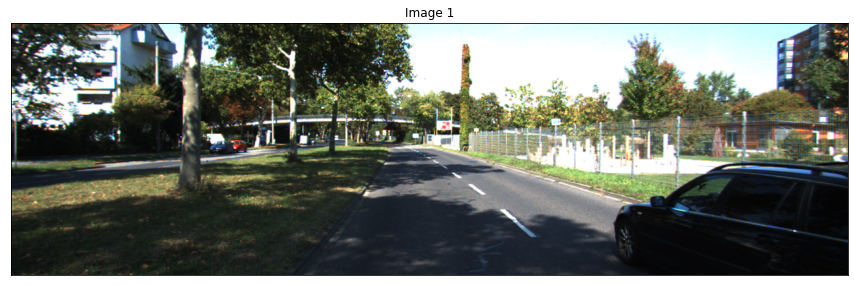

In [ ]:
# Show the first image of the video sequence
plt.figure(figsize=(15,15))
plt.title("Image 1"), plt.xticks([]), plt.yticks([])
plt.imshow(video_sequence[0])

## 1.2 Import bounding boxes labels

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import cv2 as cv

def parse(filepath):
  '''
      Parse gt.txt with format
        <frame>, <id>, <type>, <truncated>, <occluded>, <alpha>, <bb_left>, <bb_top>, <bb_right>, <bb_bottom>, <3D_H>, <3D_W>, <3D_L>, <x>, <y>, <z>, <ry>
      Return dict as:
        <type> = "Car", "Van", "Truck", "Pedastrian", "Person_sitting", "Cyclist", "Tram", "Misc", "DontCare"
        key: frame
        value: list - <id>, <bb_left>, <bb_top>, <bb_right>, <bb_bottom>, <is_vehicle>
      Feel free to edit your structure as needed!
  '''

  used_type = ["Car", "Van", "Truck", "Tram"]

  lines = open(filepath, "r").readlines()                                 
  bbox = {}

       #  <frame>, <id>, <truncated>, <occluded>, <alpha>, <bb_left>, <bb_top>, <bb_right>, <bb_bottom>, <3D_H>, <3D_W>, <3D_L>, <x>,   <y>,   <z>,   <ry>
  mask = [False,   False,  False,       False,      False,   True,      True,     True,       True,        False,  False,  False,  False, False, False, False]
  
  for line in lines:
    l = line.strip().split(' ') #convert line to list
    typ = l.pop(2)  # get type of bbox 
    line = np.asarray(l).astype(np.float32) # convert into array 
    frame, line = int(line[0]), line[mask] # get frame number and mask the line   
    if frame not in bbox.keys():
      bbox[frame] = []   
    if typ in used_type:
        bbox[frame].append(line)

  for frame in bbox.keys():
    bbox[frame] = np.asarray(bbox[frame], np.int32)

  return bbox

def add_bbox(img, bbox, color=(255, 0, 0), thickness=2):
  ''' 
    annotate an image with bounding boxes:
    supports single bbox or list of bboxs
  '''

  annotated = np.copy(img)

  if len(bbox)!=0:
    if isinstance(bbox[0], np.ndarray) or isinstance(bbox[0], list):
        for (x1,y1,x2,y2) in bbox:
            cv.rectangle(annotated, (x1, y1), (x2, y2), color , thickness)
    else:
        x1,y1,x2,y2 = bbox
        cv.rectangle(annotated, (x1, y1), (x2, y2), color , thickness)
  
  return annotated

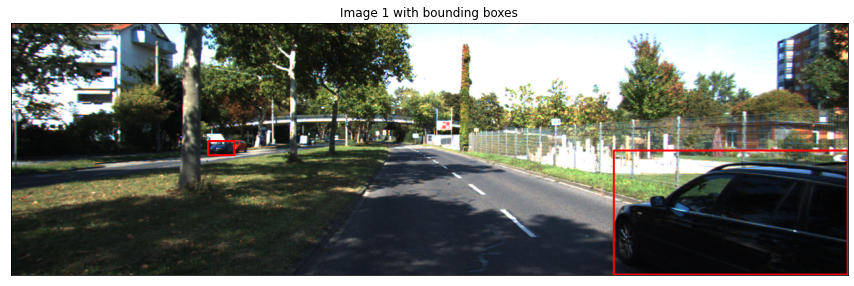

In [ ]:
filepath="/content/drive/MyDrive/ECSE 415/ECSE 415 - Final Project/dataset/0003.txt"

ground_truth = parse(filepath)

image = add_bbox(video_sequence[0], ground_truth[0])

plt.figure(figsize=(15,15))
plt.title("Image 1 with bounding boxes"), plt.xticks([]), plt.yticks([])
plt.imshow(image)

In [ ]:
bboxes = []

for frame_id in range(len(ground_truth.keys())):    
    bboxes.append(ground_truth[frame_id])

# 2. Lucas-Kanade Tracker

Code adapted from: 

1. Tutorial 11 & 12
2. https://docs.opencv.org/3.4/d4/dee/tutorial_optical_flow.html
3. https://github.com/opencv/opencv/blob/3.4/samples/python/lk_track.py

### 2.1 Import detection model

In [ ]:
# Load model
model = loadModel(model_path)

In [ ]:
# Normalize picture before detection
def normalized(img):
  return np.array(img, dtype=np.float32) / 255

# methods: nms, group, heatmap
def detect(img, method, model):
  norm_img = normalized(img)
  bboxes = detectVehicles(norm_img, model, merging_type=method, nmsOverlapThresh=0.3, heatmapThresh=3, show=False)
  #print("detected: " + str(len(bboxes)))
  return bboxes

### 2.2 Helper Methods

In [ ]:
# Draw bbox from new points using min and max points
def draw_bbox(img, points):

  #draw bbox on temp_img
  y = points[:,:,1]
  x = points[:,:,0]
  min_x = np.min(x)
  max_x = np.max(x)
  min_y = np.min(y)
  max_y = np.max(y)

  bbox = np.array([min_x, min_y, max_x, max_y], dtype=np.int32)
  img = add_bbox(img, bbox.tolist())

  return img, bbox

In [ ]:
# Draw bbox from new points (mean or median)
def draw_bbox2(img, minx, miny, maxx, maxy, good_new, good_old):

  #draw bbox on temp_img
  y_new = good_new[:,:,1]
  x_new = good_new[:,:,0]
  y_old = good_old[:,:,1]
  x_old = good_old[:,:,0]

  yv = np.mean(y_new - y_old)
  xv = np.mean(x_new - x_old)

  new_bbox = np.array([int(minx+xv), int(miny+yv), int(maxx+xv), int(maxy+yv)])
  img = add_bbox(img, new_bbox)

  return img, new_bbox

In [ ]:
# Draw colorful tracks of motion
def draw_tracks(img, good_new, good_old):

  # create some random colors
  color = np.random.randint(0, 255, (good_new.shape[0], 3))
  
  for i, (new, old) in enumerate(zip(good_new, good_old)):
    a, b = new.ravel()
    c, d = old.ravel()
    img = cv2.line(img, (a,b), (c,d), color[i].tolist(), 2)

  return img

In [ ]:
# Create array of tracking points from bounding box
def get_p0(minx, miny, maxx, maxy, step):

  p0 = []
  x = np.arange(minx,maxx, step)
  y = np.arange(miny, maxy, step)  
  for idx in x:
    for idy in y:
      p0.append((idx, idy))
  
  p0 = np.array(p0, dtype=np.float32)
  p0 = np.expand_dims(p0, axis=1)

  return p0

In [ ]:
# Display image with frame number
def display_frame(id, frame):
  plt.figure(figsize=(15,15))
  plt.imshow(frame)
  plt.title("Frame " + str(id)), plt.xticks([]), plt.yticks([])
  plt.show()
  return 0

In [ ]:
# save image and display
def save_frame(id, frame, video_sequence, fig):
    
    image = plt.imshow(frame, animated=True)
    video_sequence.append([image])
    #plt.title("Frame " + str(id)), plt.xticks([]), plt.yticks([])
    #plt.show()


### 2.3 Tracker implementation

In [ ]:
def lk_tracker_init(video_sequence, method, model, fig):
  frame_idx = 0
  annoted_video_sequence = []
  all_tracks = []

  # Read first frame
  frame = video_sequence[frame_idx]

  # Perform localization/detection
  tracks = detect(frame, method, model)

  # Keep detecting until a vehicle is detected
  while len(tracks) == 0:
    #image = plt.imshow(frame, animated=True)
    #annoted_video_sequence.append([image])
    save_frame(frame_idx, frame, annoted_video_sequence, fig)
    all_tracks.append(np.array([[0,0,0,0]]))
    
    frame_idx += 1 
    frame = video_sequence[frame_idx]
    tracks = detect(frame, method, model)

  # Once detection is successful
  # Draw bounding box
  temp_img = add_bbox(frame, tracks)

  # Save image and bboxes
  #image = plt.imshow(temp_img, animated=True)
  #annoted_video_sequence.append([image])
  save_frame(frame_idx, temp_img, annoted_video_sequence, fig)
  all_tracks.append(tracks)

  # Convert image to grayscale
  frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

  # Update frame id and prev_frame 
  frame_idx += 1
  prev_gray = frame_gray

  return annoted_video_sequence, all_tracks, prev_gray, frame_idx, fig


In [ ]:
def lk_tracker(video_sequence, method, model, annoted_video_sequence, all_tracks, prev_gray, frame_idx, detect_interval, fig):

  # Optical flow params
  lk_params = dict( winSize  = (15, 15),
                    maxLevel = 2,
                    criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 0.03))

  tracks = all_tracks[frame_idx-1]
  count = 1

  while frame_idx < len(video_sequence):

    # Read next frame
    frame = video_sequence[frame_idx]
    temp_img = frame.copy()

    if len(tracks) > 0:

      ##### Tracking #####
      if count < detect_interval:
        
        # Convert image to grayscale
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        # Perform tracking
        new_tracks, temp_img, frame_gray = tracking(frame_gray, tracks, prev_gray, temp_img)
      
      ##### Detection #####
      else: 
        # Perform localization/detection
        new_tracks = detect(frame, method, model)

        # Keep detecting until a vehicle is detected
        while len(tracks) == 0:
          #image = plt.imshow(frame, animated=True)
          #annoted_video_sequence.append([image])
          save_frame(frame_idx, frame, annoted_video_sequence, fig)
          all_tracks.append(np.array([[0,0,0,0]]))
          
          frame_idx += 1 
          frame = video_sequence[frame_idx]
          new_tracks = detect(frame, method, model)

        # Once detection is successful
        # Draw bounding box
        temp_img = add_bbox(frame, tracks)   
        # Convert image to grayscale
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        # Reinitialize counter
        count = 0
       
    # Store image 
    #image = plt.imshow(temp_img, animated=True)
    #annoted_video_sequence.append([image])
    save_frame(frame_idx, temp_img, annoted_video_sequence, fig)
    # Store new tracks
    all_tracks.append(np.array(new_tracks)) 
    # Update variables for next iteration
    frame_idx += 1
    count += 1
    prev_gray = frame_gray
    tracks = new_tracks 

  return annoted_video_sequence, all_tracks, fig

In [ ]:
def tracking(frame_gray, tracks, prev_gray, temp_img):

  new_tracks = []

  for (minx, miny, maxx, maxy) in tracks:        
    # Get original tracking points
    p0 = get_p0(minx, miny, maxx, maxy, step=1)
    # Calculate optical flow points
    p1, st1, _ = cv2.calcOpticalFlowPyrLK(prev_gray, frame_gray, p0, None, **lk_params)
    # Back-check the optical flow 
    p0r, st0r, _ = cv2.calcOpticalFlowPyrLK(frame_gray, prev_gray, p1, None, **lk_params)  
    # Distance between the two optical flow operations
    d = abs(p0-p0r).reshape(-1, 2).max(-1)
    # Mask for good points
    good_mask = d < 1 
    # select good points
    good_new = p1[good_mask==1]
    good_old = p0[good_mask==1]

    # Draw and get bbox
    temp_img, bbox = draw_bbox2(temp_img, minx, miny, maxx, maxy, good_new, good_old)
    # append new bbox to new_tracks
    new_tracks.append(bbox)

  return new_tracks, temp_img, frame_gray

In [ ]:
def lk_vehicleTracker(video_sequence, method, model, detect_interval):
    fig = plt.figure(figsize=(15,15))
    annoted_video_sequence, all_tracks, prev_gray, frame_idx, fig = lk_tracker_init(video_sequence, method, model, fig)
    annoted_video_sequence, all_tracks, fig = lk_tracker(video_sequence, method, model, annoted_video_sequence, all_tracks, prev_gray, frame_idx, detect_interval, fig)

    return annoted_video_sequence, all_tracks, fig


### 2.4 Tracker Video

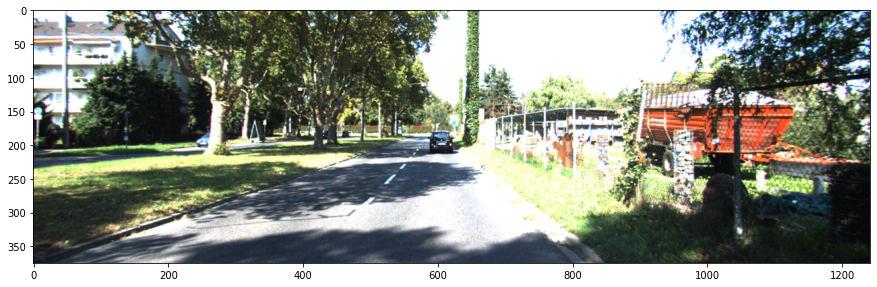

In [ ]:
video, tracks, fig = lk_vehicleTracker(video_sequence, "nms", model, detect_interval=5)

In [ ]:
ani = animation.ArtistAnimation(fig, video, interval=1000/30, blit=True, repeat_delay=1000)
ani.save(project_path+'/vehicles3_lk_tracker.mp4')

### 2.5 Tracker Evaluation

In [ ]:
def computeMeanIoU(gt_bboxes, pred_bboxes):
    total_iou = 0
    for pred_box in pred_bboxes:
        max_iou = 0
        for gt_box in gt_bboxes:
            cur_iou = iou(pred_box, gt_box)
            if max_iou < cur_iou:
                max_iou = cur_iou

        total_iou += max_iou

    if len(pred_bboxes) == 0:
        avg_iou = 0.5
    else:
        avg_iou = total_iou / len(pred_bboxes)

    return avg_iou

In [ ]:
def iou(a, b):
    # determine the (x, y)-coordinates of the intersection rectangle
    xi = max(a[0], b[0])
    yi = max(a[1], b[1])
    xf = min(a[2], b[2])
    yf = min(a[3], b[3])
    # compute the area of intersection rectangle
    interArea = max(0, xf - xi + 1) * max(0, yf - yi + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    aArea = (a[2] - a[0] + 1) * (a[3] - a[1] + 1)
    bArea = (b[2] - b[0] + 1) * (b[3] - b[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(aArea + bArea - interArea)
    # return the intersection over union value
    return iou

In [ ]:
ious = []
for i, preds in enumerate(tracks):
  gt_bboxes = bboxes[i]
  pred_bboxes = preds  
  avg_iou = computeMeanIoU(gt_bboxes, pred_bboxes)
  
  ious.append(avg_iou)


print(mean(ious))
print(median(ious))


0.3763906264473525
0.38681649536864326


# 3. Other Tracker

In [ ]:
def alt_tracking(video_sequence, method, interval, fig): 

  # define initial bounding box using detection
  i = 0
  bboxes = []


  print(len(video_sequence))

  while len(bboxes) == 0:
    frame = video_sequence[i]
    bboxes = detect(frame, method, model)
    i = i + 1

  # tracker code adapted from Tutorial 12 and https://learnopencv.com/multitracker-multiple-object-tracking-using-opencv-c-python/
  # create tracker 
  tracker = cv2.TrackerMIL_create()

  bbox = tuple(bboxes[0])
  ok = tracker.init(frame, bbox)
  images = []

  while True: 

    # read the next frame -> break if at last frame
    i = i+1
    if not ok:
      print("Something went wrong")
      break

    if i == (len(video_sequence) - 1): 
      print("loop complete")
      break

    frame = video_sequence[i]

    # redetect every {interval} frames
    if i % interval == 0: 
      bboxes = detect(frame, method, model)
      if len(bboxes) > 0:
        bbox = tuple(bboxes[0])
        ok = tracker.init(frame, tuple(bbox))

    # update tracker
    ok, bbox = tracker.update(frame)

    # tracking success
    p1 = (int(bbox[0]), int(bbox[1]))
    p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
    frame_copy = frame
    img = cv2.rectangle(frame_copy, p1, p2, (255,0,0), 2, 1)
    im = plt.imshow(img, animated=True)

    # plt.imshow(frame_copy, animated=True)
    # plt.show()
    images.append([im])

  return images, fig
  

144
loop complete


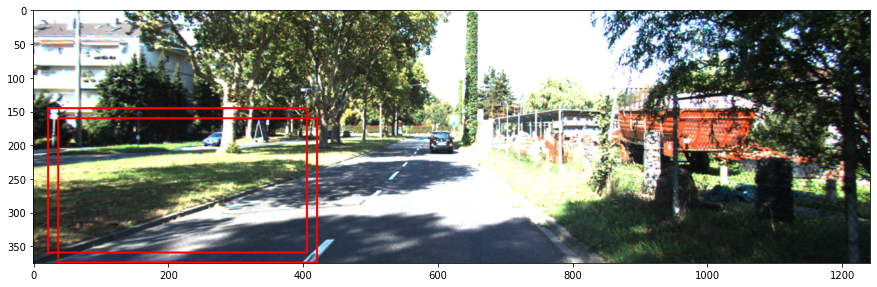

In [ ]:
fig = plt.figure(figsize=(15,15))
images, fig = alt_tracking(video_sequence, "nms", 24, fig)


ani = animation.ArtistAnimation(fig, images, interval=1000/30, blit=True, repeat_delay=1000)
ani.save(project_path+'/alternate_tracking_method.mp4')